<a href="https://colab.research.google.com/github/Swethan-colab/Sonu27/blob/main/3DCNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import copy


In [67]:
# Replace 'path/to/my/file.h5' with the actual path to your .h5 file in your Drive
data_path = '/content/drive/MyDrive/data1000_51voxels.h5'
import h5py

with h5py.File(data_path, 'r') as f:  # Open the file in read-only mode
    # Assuming your RVE data is stored in a dataset named 'rve_data' within the file
    QoIPCAH = f['QoIPCAH'][:]  # Load the data as a NumPy array
    X = f['X'][:]

# Check the data shape to ensure it's 3D (channels, width, height, depth)
print(X.shape,QoIPCAH.shape
 )

(1000, 1, 51, 51, 51) (1000, 6)


In [69]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets (excluding validation for now)
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(X, QoIPCAH, test_size=0.1, random_state=42)

# Further split training and validation sets (from X_train_val and y_train_val)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_val, y_train_val, test_size=0.16, random_state=42)

X_train = torch.from_numpy(X_train_).float()  # Train data
X_val = torch.from_numpy(X_val_).float()  # Validation data
X_test = torch.from_numpy(X_test_).float()  # Test data

print(f"")

y_train = torch.from_numpy(y_train_).float()  # Train labels
y_val = torch.from_numpy(y_val_).float()  # Validation labels
y_test = torch.from_numpy(y_test_).float()  # Test labels

In [70]:
epochs = 30
batch_size = 32
patience = 5  # Early stopping patience
learning_rate = 0.001

In [71]:
# Normalize the image data (optional)
transform = transforms.Normalize(mean=[0.5], std=[0.5])

# Create datasets
train_dataset = TensorDataset(transform(X_train), y_train)
val_dataset = TensorDataset(transform(X_val), y_val)
test_dataset = TensorDataset(transform(X_test), y_test)
batch_size=32
data_sample, target = test_dataset[17]  # Access first element

print(data_sample.shape)  # Check the shape of the data sample (e.g., torch.Size([1, 3, 32, 32, 32]))
print(target)

# Create dataloaders for efficient batch training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([1, 51, 51, 51])
tensor([201.2158, 123.2615,  46.5704,  50.1400,   0.2041,   0.3234])


In [72]:



class My3DCNN(nn.Module):
  def __init__(self, input_shape, output_size):
    super(My3DCNN, self).__init__()
    self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
    self.bn1 = nn.BatchNorm3d(16)  # BatchNorm after conv1
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
    self.bn2 = nn.BatchNorm3d(16)  # BatchNorm after conv2
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
    self.bn3 = nn.BatchNorm3d(32)  # BatchNorm after conv3
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=6912, out_features=128)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=64)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=64, out_features=output_size)
    for name, param in self.named_modules():
      if isinstance(param, nn.Conv3d):
        nn.init.kaiming_normal_(param.weight)

  def forward(self, x):
    x = self.bn1(self.relu1(self.conv1(x)))  # Apply BatchNorm after ReLU
    x = self.pool1(x)

    x = self.bn2(self.relu2(self.conv2(x)))  # Apply BatchNorm after ReLU
    x = self.pool2(x)

    x = self.bn3(self.relu3(self.conv3(x)))  # Apply BatchNorm after ReLU
    x = self.pool3(x)

    x = self.flatten(x)
    x = self.relu4(self.fc1(x))
    x = self.relu5(self.fc2(x))
    x = self.fc3(x)
    return x


In [73]:
import matplotlib.pyplot as plt

def evaluate(model, val_dataloader, criterion):
    model.eval()  # Set model to evaluation mode (optional for some layers)
    with torch.no_grad():
        total_val_loss = 0
        for data, target in val_dataloader:
            output = model(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()
    return total_val_loss / len(val_dataloader)

def train_model(model, train_loader, val_loader, epochs, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adjust optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss

    training_losses = []  # Store training losses for each epoch
    validation_losses = []  # Store validation losses for each epoch

    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Train loop
        total_train_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()  # Reset gradients for each batch

            output = model(data)
            loss = criterion(output, target) + get_regularization_loss(model)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Calculate and print average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        val_loss = evaluate(model, val_dataloader, criterion)
        validation_losses.append(val_loss)
        print(f"Val Loss: {val_loss:.4f}")

        # Early stopping (implementation not shown here for brevity)

    # Plot training and validation loss (after training)
    plt.plot(range(epochs), training_losses, label='Training Loss')
    plt.plot(range(epochs), validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model weights (implementation not shown here for brevity)
    return model


In [74]:
l1_lambda = 0.001  # Adjust this hyperparameter for L1 regularization
l2_lambda = 0.005  # Adjust this hyperparameter for L2 regularization

def get_regularization_loss(model):
  # Iterate through all model parameters and sum their L1 or L2 norm
  regularization_loss = 0
  for param in model.parameters():
    if param.requires_grad:  # Only consider parameters with gradients
      regularization_loss += l1_lambda * torch.abs(param).sum()  # L1 regularization
      # OR
      regularization_loss += l2_lambda * torch.sum(torch.square(param))  # L2 regularization
  return regularization_loss

In [75]:
input_shape = X.shape[1:]
output_shape = QoIPCAH.shape[1]
model = My3DCNN(input_shape,output_shape)
#clip_value = 0.005  # Experiment with different clip values
#torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)  # Stochastic Gradient Descent optimizer


Epoch 1/30, Train Loss: 3636.8944
Val Loss: 150.4074
Epoch 2/30, Train Loss: 348.9425
Val Loss: 59.6892
Epoch 3/30, Train Loss: 37.6802
Val Loss: 4.5176
Epoch 4/30, Train Loss: 18.1277
Val Loss: 5.1961
Epoch 5/30, Train Loss: 14.5097
Val Loss: 0.9916
Epoch 6/30, Train Loss: 12.7640
Val Loss: 0.7454
Epoch 7/30, Train Loss: 12.3055
Val Loss: 0.7034
Epoch 8/30, Train Loss: 11.9585
Val Loss: 0.3610
Epoch 9/30, Train Loss: 11.5417
Val Loss: 0.2788
Epoch 10/30, Train Loss: 11.2915
Val Loss: 0.3026
Epoch 11/30, Train Loss: 11.1302
Val Loss: 0.2243
Epoch 12/30, Train Loss: 10.9026
Val Loss: 0.2234
Epoch 13/30, Train Loss: 10.7119
Val Loss: 0.1870
Epoch 14/30, Train Loss: 10.5112
Val Loss: 0.2295
Epoch 15/30, Train Loss: 10.5091
Val Loss: 0.4670
Epoch 16/30, Train Loss: 10.4248
Val Loss: 0.2517
Epoch 17/30, Train Loss: 10.1211
Val Loss: 0.2069
Epoch 18/30, Train Loss: 10.0211
Val Loss: 0.2384
Epoch 19/30, Train Loss: 9.9148
Val Loss: 0.1650
Epoch 20/30, Train Loss: 9.7629
Val Loss: 0.1569
Epoch

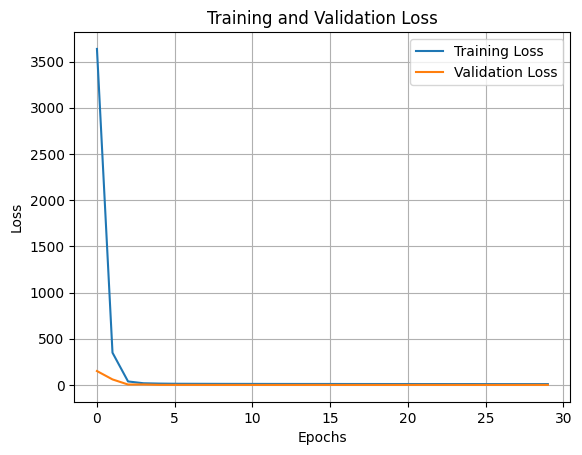

My3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (bn3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6912, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=

In [76]:
train_model(model,train_dataloader,val_dataloader,30,5)

In [61]:
test_loss = evaluate(model,test_dataloader,criterion)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0046
